# Introduction

According to ECOMMERCE PLATFORMS (https://ecommerce-platforms.com/glossary/brick-mortar-store)

A brick and mortar store is a business or retail outlet that has at least one physical location. Traditional stores that you find in your local shopping mall are known as brick and mortar stores, for example.

Although the overheads associated with a brick and mortar store are far higher than if your business is simply an eCommerce venture, the necessity for a brick and mortar store for the highest conversion rates is becoming more pronounced. In fact in the USA offline sales are still 10x bigger than that of online sales.

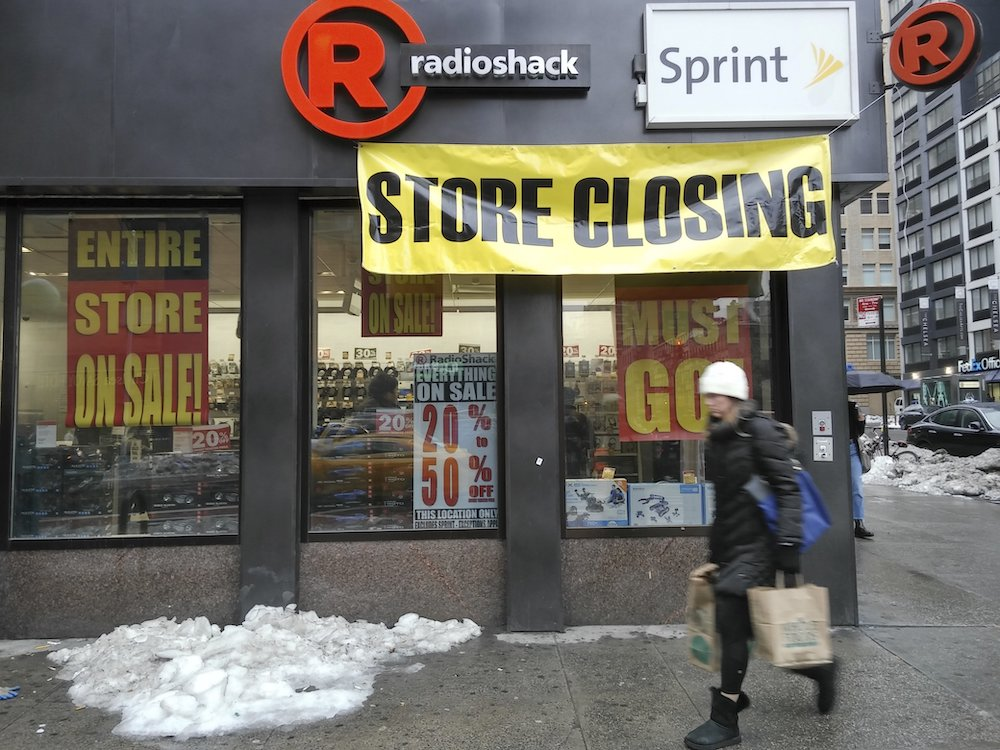

image from https://www.wsj.com/articles/brick-and-mortar-stores-are-shuttering-at-a-record-pace-1492818818

In this notebook, I tried brick and mortar store sales analysis and how we can improve them.

# Importing and Features Engineering

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/stores-area-and-sales-data/Stores.csv


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [3]:
df=pd.read_csv('/stores-area-and-sales-data/Stores.csv')

In [4]:
df.head()

,Store ID,Store_Area,Items_Available,Daily_Customer_Count,Store_Sales
0,1,1659,1961,530,66490
1,2,1461,1752,210,39820
2,3,1340,1609,720,54010
3,4,1451,1748,620,53730
4,5,1770,2111,450,46620


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 896 entries, 0 to 895
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype
---  ------                --------------  -----
 0   Store ID              896 non-null    int64
 1   Store_Area            896 non-null    int64
 2   Items_Available       896 non-null    int64
 3   Daily_Customer_Count  896 non-null    int64
 4   Store_Sales           896 non-null    int64
dtypes: int64(5)
memory usage: 35.1 KB


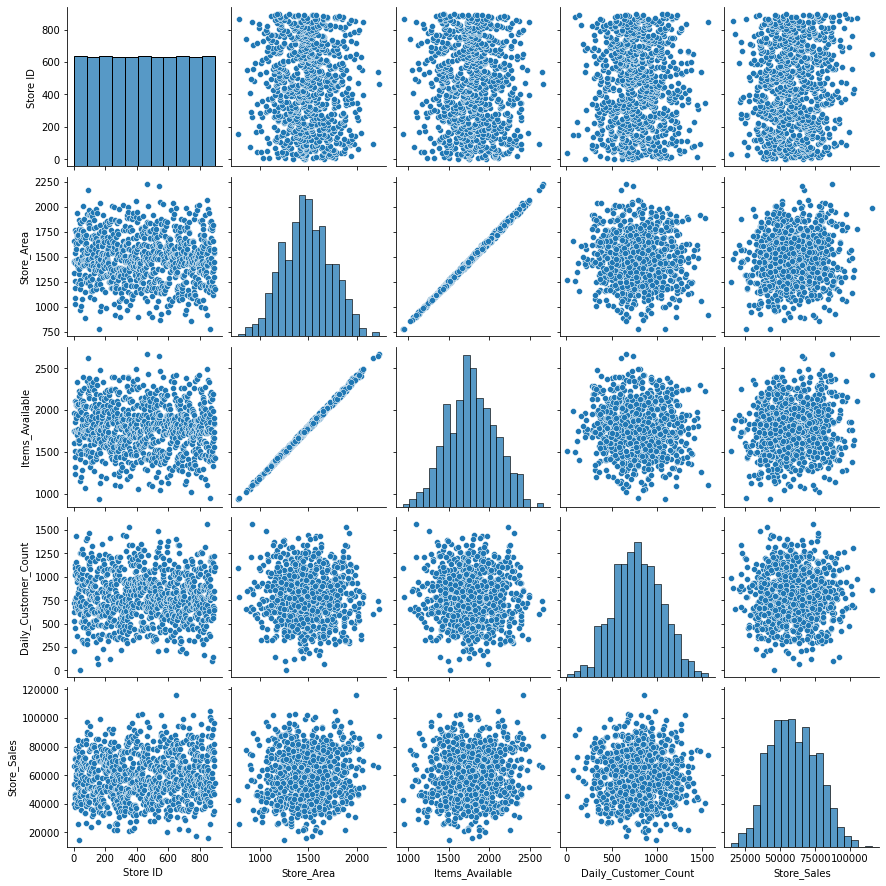

In [6]:
sns.pairplot(df)

<AxesSubplot:>

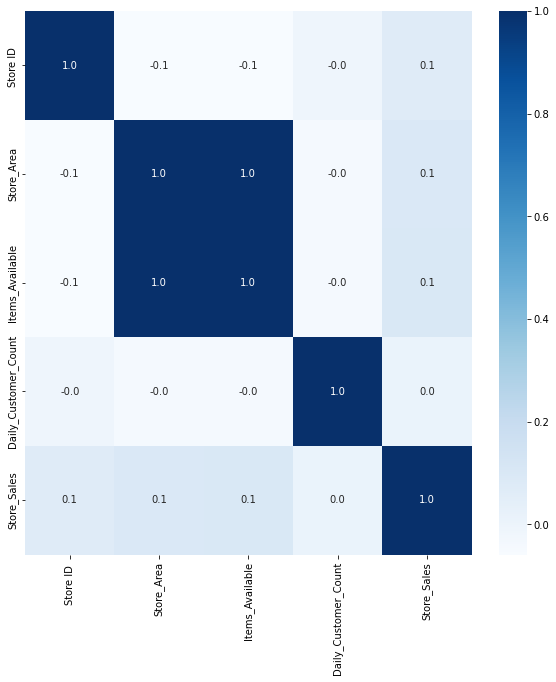

In [7]:
plt.figure(figsize = (10,10))
sns.heatmap(df.corr(),annot=True, cbar=True, cmap='Blues', fmt='.1f')

* Store_Area and Items_Available is 100% positive correlation.
* But there are no strong positive correlation between Store_Sales and Store_Area, Items_Available and Daily_Customer_Count, although I have thought that there are strong positive correlation among them...

As next step, I added new features,'Salese Efficiency'
* Sales Floor Efficiency : 'Store_Sales' divided by 'Store_Area'
* Item Unit Sales : 'Store_Sales' divided by 'Items_Available'
* Customer Unit Sales : 'Store_Sales' divided by 'Daily_Customer_Count'

In [8]:
df['Sales_Floor_Efficiency']=df['Store_Sales']/df['Store_Area']
df['Item_Unit_Sales']=df['Store_Sales']/df['Items_Available']
df['Customer_Unit_Sales']=df['Store_Sales']/df['Daily_Customer_Count']

In [9]:
df.head()

,Store ID,Store_Area,Items_Available,Daily_Customer_Count,Store_Sales,Sales_Floor_Efficiency,Item_Unit_Sales,Customer_Unit_Sales
0,1,1659,1961,530,66490,40.078360,33.906170,125.452830
1,2,1461,1752,210,39820,27.255305,22.728311,189.619048
2,3,1340,1609,720,54010,40.305970,33.567433,75.013889
3,4,1451,1748,620,53730,37.029635,30.737986,86.661290
4,5,1770,2111,450,46620,26.338983,22.084320,103.600000


I tried to find “minimum”, first quartile (Q1), median, third quartile (Q3), and “maximum” of each features by boxplot.

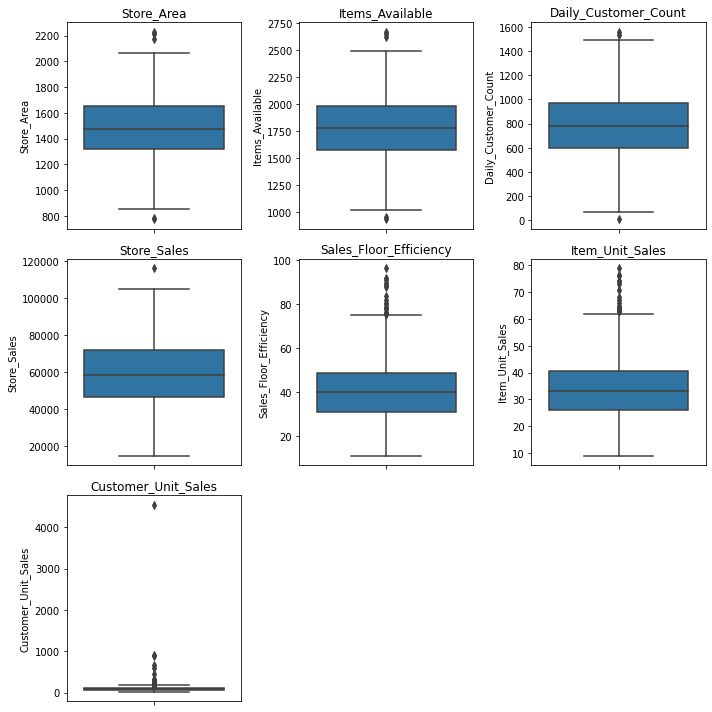

In [10]:
num_list=['Store_Area', 'Items_Available', 'Daily_Customer_Count',
       'Store_Sales', 'Sales_Floor_Efficiency', 'Item_Unit_Sales', 'Customer_Unit_Sales']
fig = plt.figure(figsize=(10,10))

for i in range(len(num_list)):
    plt.subplot(3,3,i+1)
    plt.title(num_list[i])
    sns.boxplot(data=df,y=df[num_list[i]])

plt.tight_layout()

There seems to be the outliar in Customer_Unit_Sales. It means that there are some outliers in Store_Sales and/or Daily_Customer_Count. Where is the outliers ?

I tried value sort by Customer_Unit_Sales.

In [11]:
df.sort_values(by="Customer_Unit_Sales",ascending=False) 

,Store ID,Store_Area,Items_Available,Daily_Customer_Count,Store_Sales,Sales_Floor_Efficiency,Item_Unit_Sales,Customer_Unit_Sales
39,40,1270,1516,10,45480,35.811024,30.000000,4548.000000
151,152,1662,1986,70,63730,38.345367,32.089627,910.428571
876,877,1259,1493,100,88270,70.111199,59.122572,882.700000
887,888,1156,1398,140,92370,79.904844,66.072961,659.785714
230,231,1347,1628,120,72350,53.711952,44.441032,602.916667
...,...,...,...,...,...,...,...,...
223,224,1318,1606,1200,24410,18.520486,15.199253,20.341667
852,853,1477,1790,880,16370,11.083277,9.145251,18.602273
670,671,1461,1739,1250,22310,15.270363,12.829212,17.848000
372,373,1876,2254,1340,21650,11.540512,9.605146,16.156716


Daily_Customer_Count '10' of store ID 40 seems to be the outlier. So I dropped Store ID 40.

In [12]:
df=df.drop(df.index[39])

In [13]:
df = df.reset_index(drop=True)

# Clustering

In [14]:
pip install pycaret --ignore-installed llvmlite numba

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 320.2/320.2 kB 995.7 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.5/34.5 MB 17.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 25.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 274.2/274.2 kB 14.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 35.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 435.2/435.2 kB 21.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.2/15.2 MB 21.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 49.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.0/307.0 kB 17.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 25.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.4/123.4 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 26.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [15]:
conda install -c numba llvmlite

Solving environment: \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - done

## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - llvmlite


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    llvmlite-0.38.0            |   py37he1b5a44_0        28.2 MB  numba
    openssl-1.1.1q             |       h166bdaf_0         2.1 MB  conda-forge
    ------------------------------------------------------------
                                           Total:        30.3 MB

The following packages will be UPDATED:

  openssl                                

In [16]:
pip install numba --upgrade

  Using cached numba-0.55.2-cp37-cp37m-manylinux2014_x86_64.manylinux_2_17_x86_64.whl (3.3 MB)
  Attempting uninstall: numba
    Found existing installation: numba 0.55.1
    Uninstalling numba-0.55.1:
      Successfully uninstalled numba-0.55.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pycaret 2.3.10 requires gensim<4.0.0, but you have gensim 4.0.1 which is incompatible.
pycaret 2.3.10 requires imbalanced-learn==0.7.0, but you have imbalanced-learn 0.9.0 which is incompatible.
pycaret 2.3.10 requires numba<0.55, but you have numba 0.55.2 which is incompatible.
pycaret 2.3.10 requires pyyaml<6.0.0, but you have pyyaml 6.0 which is incompatible.
pycaret 2.3.10 requires scikit-learn==0.23.2, but you have scikit-learn 1.0.2 which is incompatible.
pycaret 2.3.10 requires scipy<=1.5.4, but you have scipy 1.7.3 which is incompatible.
Note: you may need to resta

In [17]:
from pycaret.clustering import *

In [18]:
df

,Store ID,Store_Area,Items_Available,Daily_Customer_Count,Store_Sales,Sales_Floor_Efficiency,Item_Unit_Sales,Customer_Unit_Sales
0,1,1659,1961,530,66490,40.078360,33.906170,125.452830
1,2,1461,1752,210,39820,27.255305,22.728311,189.619048
2,3,1340,1609,720,54010,40.305970,33.567433,75.013889
3,4,1451,1748,620,53730,37.029635,30.737986,86.661290
4,5,1770,2111,450,46620,26.338983,22.084320,103.600000
...,...,...,...,...,...,...,...,...
890,892,1582,1910,1080,66390,41.965866,34.759162,61.472222
891,893,1387,1663,850,82080,59.178082,49.356584,96.564706
892,894,1200,1436,1060,76440,63.700000,53.231198,72.113208
893,895,1299,1560,770,96610,74.372594,61.929487,125.467532


In [19]:
df1=df.drop(['Store ID '],axis=1)

In [20]:
exp_clust = setup(df1, normalize = True,session_id = 123,silent=True)

,Description,Value
0,session_id,123
1,Original Data,"(895, 7)"
2,Missing Values,False
3,Numeric Features,7
4,Categorical Features,0
5,Ordinal Features,False
6,High Cardinality Features,False
7,High Cardinality Method,None
8,Transformed Data,"(895, 7)"
9,CPU Jobs,-1


In [21]:
kmeans = create_model('kmeans',num_clusters = 5)

,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.2488,303.785,1.065,0,0,0


How many clusters are appropriate ?

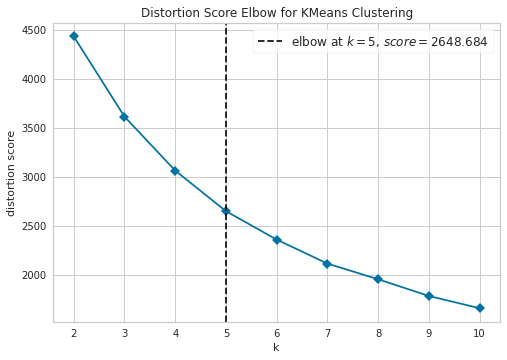

In [22]:
plot_model(kmeans, plot = 'elbow')

5 clusters are appropriate.

In [23]:
kmean_results = assign_model(kmeans)

Are there any gap among clusters ?

In [24]:
kmean_results.groupby('Cluster').mean()

,Store_Area,Items_Available,Daily_Customer_Count,Store_Sales,Sales_Floor_Efficiency,Item_Unit_Sales,Customer_Unit_Sales
Cluster,,,,,,,
Cluster 0,1631.828000,1958.432000,714.240000,73330.160000,45.112172,37.586396,118.824405
Cluster 1,1304.364662,1565.304511,841.804511,47885.751880,36.861846,30.715003,62.102527
Cluster 2,1227.895833,1472.826389,832.847222,76739.236111,63.011882,52.522973,101.859060
Cluster 3,1700.243478,2038.552174,789.521739,46248.043478,27.162822,22.655683,66.576282
Cluster 4,1373.200000,1651.000000,112.000000,75128.000000,56.586656,47.078953,701.812344


We can find some gap in means among clusters.
* Store_Area : Cluster 3 has max and Cluster 0 has min.
* Items_Available : Cluster 3 has max and Cluster 2 has min.
* Daily_Customer_Count : Cluster 1 has max and Cluster 4 has min.
* Store_Sales : Cluster 2 has max and Cluster 3 has min.
* Sales_Floor_Efficiency : Cluster 2 has max and Cluster 3 has min.
* Item_Unit_Sales : Cluster 2 has max and Cluster 3 has min.
* Customer_Unit_Sales : Cluster 4 has max and Cluster 1 has min.

In [25]:
plot_model(kmeans, plot = 'distribution')

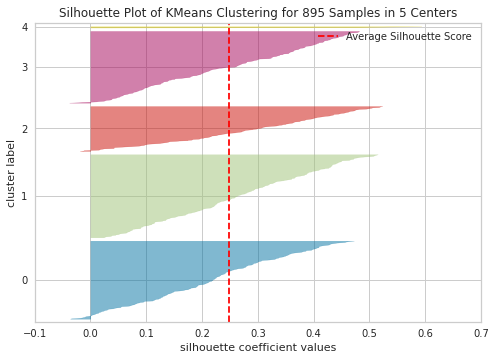

In [26]:
plot_model(kmeans, plot = 'silhouette')

In [27]:
plot_model(kmeans)

In [28]:
plot_model(kmeans, plot = 'tsne')

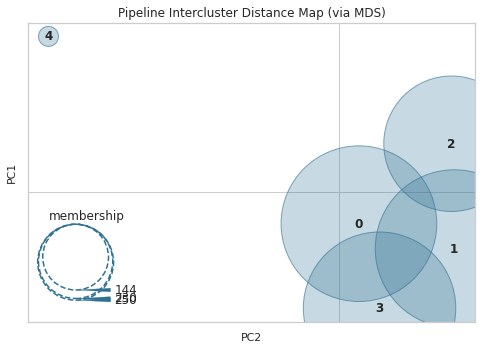

In [29]:
plot_model(kmeans, plot = 'distance')

In [30]:
plot_model(kmeans, plot = 'distribution', feature = 'Store_Area')

In [31]:
plot_model(kmeans, plot = 'distribution', feature = 'Items_Available')

In [32]:
plot_model(kmeans, plot = 'distribution', feature = 'Daily_Customer_Count')

In [33]:
plot_model(kmeans, plot = 'distribution', feature = 'Store_Sales')

In [34]:
plot_model(kmeans, plot = 'distribution', feature = 'Sales_Floor_Efficiency')

In [35]:
plot_model(kmeans, plot = 'distribution', feature = 'Item_Unit_Sales')

In [36]:
plot_model(kmeans, plot = 'distribution', feature = 'Customer_Unit_Sales')

In [37]:
df2=kmean_results.groupby('Cluster').mean()

# Insight

I tried to make marix with Scale and Efficiency. Scale shows Store_Area and Items_Available, and Efficiency shows Sales_Floor_Efficiency and Item_Unit_Sales.

* Cluster 0 and 3 have large scale, which means that large store area and a lot of items.
* Cluster 1 and 2 have not so large scale, which means that small or mid size store area and not so many items.
* Cluster 4 has high efficiency with middle scale.

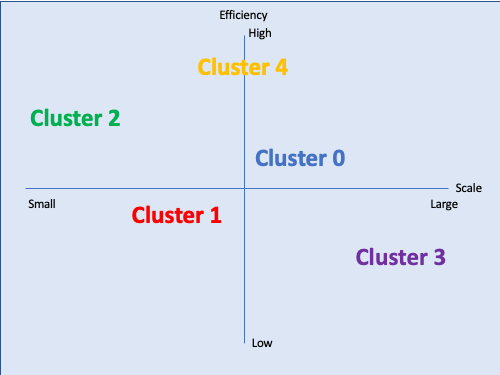

What is the strategies of each cluster if we can not change Store_Area which are fixed ?

To deepen my understanding, I added further features which I can find  other efficiencies with area.
* Items/Area
* Customer/Area

In [38]:
df2=kmean_results.groupby('Cluster').mean()
df2['Items/Area']=df2['Items_Available']/df2['Store_Area']
df2['Customer/Area']=df2['Daily_Customer_Count']/df2['Store_Area']
df2

,Store_Area,Items_Available,Daily_Customer_Count,Store_Sales,Sales_Floor_Efficiency,Item_Unit_Sales,Customer_Unit_Sales,Items/Area,Customer/Area
Cluster,,,,,,,,,
Cluster 0,1631.828000,1958.432000,714.240000,73330.160000,45.112172,37.586396,118.824405,1.200146,0.437693
Cluster 1,1304.364662,1565.304511,841.804511,47885.751880,36.861846,30.715003,62.102527,1.200051,0.645375
Cluster 2,1227.895833,1472.826389,832.847222,76739.236111,63.011882,52.522973,101.859060,1.199472,0.678272
Cluster 3,1700.243478,2038.552174,789.521739,46248.043478,27.162822,22.655683,66.576282,1.198977,0.464358
Cluster 4,1373.200000,1651.000000,112.000000,75128.000000,56.586656,47.078953,701.812344,1.202301,0.081561


* Cluster 0 :  Customer_Unit_Sales is high (118 ) and Customer per area is low ( 0.43 ). So how they can increase the number of customers is important.
* Cluster 1 :  Customer_UnCit_Sales is low (62) and Customer per area is high ( 0.64 ). So how they can increase Customer_Unit_Sales is important.
* Cluster 2 :  Customer_UnCit_Sales is high (101) and Customer per area is high ( 0.67 ).Customer_Unit_Sales should still be improved as much as cluster 0.
* Cluster 3 :  Customer_Unit_Sales is low (66) and Customer per area is also low ( 0.46 ). So how they can increase both Customer_Unit_Sales and the number of customers is important.
* Cluster 4 :  Customer_UnCit_Sales is the highest (701) and Customer per area is the lowest ( 0.08 ). They depend on important clients. So how they can maintain them is very important.

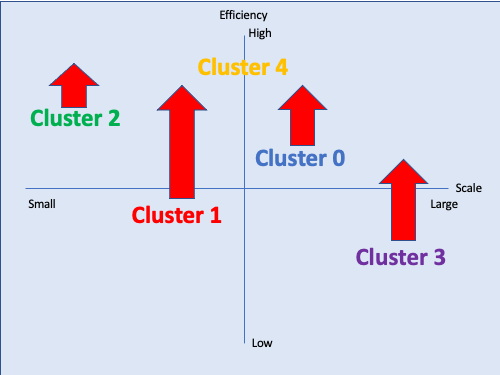

So what to do ?

In the article "Digital Marketing for Retail – Are Your Strategies Keeping Up?" (https://v12data.com/blog/digital-marketing-retail-are-your-strategies-keeping/)

We can find some tips. According to the article,

"E-commerce has gone mainstream and the lines between digital and offline channels are blurring. Consumers browse online, use their mobile devices to price check in store, and purchase through whichever channel happens to be available at the time. This is clearly the age of the consumer, which is nothing new for those working in retail. However, how big is digital really when it comes to influencing consumers? And are your digital marketing strategies keeping up?

Retail brands continue to mature digitally, using technology and the wealth of data available to more effectively connect and engage with connected consumers."

And in the article, specifically, we should 

* Use Digital to Pull Shoppers into Stores
* Improve the In-Store Experience with Digital Strategies
* Email is the Most effective Digital Channel for Personalization
* The Mobile Experience Defines Success

It means that we should understand that digital and offline channels are blurring and how we can combine them is very important.

reference: "Digital Marketing for Retail – Are Your Strategies Keeping Up?" (https://v12data.com/blog/digital-marketing-retail-are-your-strategies-keeping/)

Thank you !